# Folktales generator

*This is the final notebook - the output images were made with my latest model (where I trained 119 images).*

You can copy the relevant path to the dataset to use in the notebooks in case you are experiencing issues: "../PLI18542171_AIM_Final Mini Project/data/folk_tales_deduplicated.csv".

After training my model, I wanted to explore the realm of random generation further. In the NLP course from last semester, we explored the concept of Markov chains, which is a generative model of text data. With this, I had an idea of merging these two approaches for my project - I want to take Ukrainian folklore short stories and apply Markov chains to generate random fairytale titles and story text. Afterward, I was going to use my trained text-to-image model via DreamBooth to produce accompanying artwork for these fairytales.

The code I am using in this notebook is based on the [NLP-23-24, Week-5-Web-data-and-generative-text: Text generation with Markov Chains notebook](https://git.arts.ac.uk/tbroad/NLP-23-24/blob/main/Week-5-Web-data-and-generative-text/text-generation-with-markov-chains.ipynb) (Broad, 2023).

I am starting off by installing the Python library `markovify` that implements Markov Chains + Pandas.

In [45]:
%pip install markovify
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Here, I am conducting the import of the necessary libraries for text generation:

In [46]:
import os
import csv
import markovify
import pandas as pd

## Load files 

This line loads the data from a single text file:

In [47]:
def load_single_text_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        corpus = f.read()
        return corpus

This function loads the data from all the text files in a folder or it's subfolders.

In [48]:
def load_all_text_files_in_folder(path, max_files = 10000):
    corpus = ''
    # Find all files in the folder or subfolders
    for root, _, files in os.walk(path):
        for i, file in enumerate(files):
            # If the file is a text file
            if file.endswith(".txt") and i <= max_files:
                # Open the file and add the text to the corpus
                with open(os.path.join(root, file), 'r', encoding='utf-8') as f:
                    text = f.read()
                    # Add text from file
                    corpus += text
                    # Add new line
                    corpus += '\n'
    return corpus

This function loads in text data from a `.csv` or `.tsv` file. For a csv file (comma seperated values) we would pass in a comma in a string variable `','` as the delimeter parameter, for a tsv file (tab separated values) we would pass in a tab character in a string variable `' '` as the delimeter. 

The `col_to_extract` parameter tells us which column our text data is stored in. Here we would pass in the index of that column:

In [49]:
def load_text_from_csv(csv_file, col_to_extract, delimeter):
    corpus = ''
    # Open csv file
    with open(csv_file, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile, delimiter=delimeter)
        for row in reader:
            # Check to see there is a column where we want to extract
            if len(row) >= col_to_extract:  
                # Get text from the specific column in the row
                text = row[col_to_extract]  
                # Add text to corpus
                corpus += text
                # Add a new line
                corpus += '\n'
    return corpus

## Generating text using Markov Chains

Here is the starting point for generating text models using Markov Chains. I am loading in my [folktales dataset that I got from Kaggle](https://www.kaggle.com/datasets/andrzejpanczenko/folk-tales-dataset) (Panczenko, 2022). I picked this dataset because I am able to filter stories by nation. In this case, since I am using a Ukrainian artist, I wanted to use text from Ukrainian folklore stories. 

In [50]:
data_path = '/Users/oksanapliushko/Desktop/AI-4-Media-23-24/PLI18542171_AIM_Final Mini Project/data/folk_tales_deduplicated.csv'

#'Corpus' is a single-string variable that will store the text data for a generation. 
corpus = load_single_text_file(data_path)

### Extracting Titles

I first wanted to start by extracting just the titles of Ukrainian stories: 

In [51]:
def extract_titles_by_nation(csv_file, title_col, nation_col='nation', nation='ukrainian'):
    
    # Load the CSV file into a pandas df
    df = pd.read_csv(csv_file, encoding='utf-8')
    
    # Filter the df to only include rows with my selected nation (Ukrainian)
    filtered_df = df[df[nation_col] == nation]
    
    # Extract titles from the filtered rows
    titles = filtered_df[title_col].tolist()
    
    return titles

data_path = '/Users/oksanapliushko/Desktop/AI-4-Media-23-24/PLI18542171_AIM_Final Mini Project/data/folk_tales_deduplicated.csv'
titles = extract_titles_by_nation(data_path, title_col='title')
print(titles)

['The Beautiful Damsel and the Wicked Old Woman', 'The Tsar and the Angel', 'The Magic Egg', 'The Story of Tremsin, the Bird Zhar, and Nastasia, the Lovely Maid of the Sea', 'The Wizard', 'How a Fish Swam in the Air and a Hare in the Water', 'The Cat, the Cock and the Fox', 'The Old Dog', 'The Two Princes', 'The Ungrateful Children and the Old Father Who Went to School Again', 'The Serpent-Tsarevich and His Two Wives', 'The Snake and the Princess', 'Transmigration of the Soul', 'The Three Brothers (Robert Nisbet Bain)', 'The Story of the Forty-First Brother', 'The Origin of the Mole', 'Oh: The Tsar of the Forest', 'The Sparrow and the bush', 'The Story of the Unlucky Days', 'The Golden Slipper', 'Transformation into a Nightingale and a Cuckoo￼', 'The Straw Ox', 'The Serpent Wife', 'The Story of Unlucky Daniel', 'The Fox and the Cat (Robert Nisbet Bain)', 'The Story of Little Tsar Novishny, the False Sister, and the Faithful Beasts', 'The Story of the Wind']


### Extracting Text

To get more text for generation, now I will be separately extracting the text only for Ukrainian folklore stories:

In [52]:
def load_text_from_csv_filtered_by_nation(csv_file, title_col, nation_col='nation', nation='ukrainian'):
# Load the CSV file into a pandas df
    df = pd.read_csv(csv_file, encoding='utf-8')
    
    # Filter the df to only include rows with my selected nation (Ukrainian)
    filtered_df = df[df[nation_col] == nation]
    
    # Concatenate all text from the filtered rows into a single string
    # Used LLM to help me to finetune this extracting 
    corpus = '\n'.join(filtered_df[title_col].astype(str))
    
    return corpus

data_path = '/Users/oksanapliushko/Desktop/AI-4-Media-23-24/PLI18542171_AIM_Final Mini Project/data/folk_tales_deduplicated.csv'
corpus = load_text_from_csv_filtered_by_nation(data_path, title_col='text')
print(corpus)

In the woods stood a cottage. In it lived a man and his wife, but they had no children. Well, they went on a pilgrimage to beseech God to give them a child. God gave them a daughter. She grew and prospered. The prince about that time rode up to the place, as he was out hunting, and sent his attendant, saying: ‘Be so good as to go and ask for a draught of water at yon cottage.’ The attendant went to ask for the water just when the child was weeping, and pearls were rolling down from her eyes. Her mother pacified her; she began to smile; all manner of flowers bloomed. The servant went out and said: ‘Prince, I have seen a little girl; when she weeps, pearls roll down; and when she smiles, all manner of flowers bloom.’ The prince went into the cottage, and began to tease the child to make her cry. She cried, and pearls rolled down. He then begged her mother to pacify her. When she smiled, the prince saw that all manner of flowers bloomed.The girl continued to grow, and the prince always ro

### Generating text at the character level

In [53]:
corpus_char_list = [ list(word) for word in corpus ]
chain = markovify.Chain(corpus_char_list, state_size=5)

new_str = ''
for i in range(500):
    example_output = chain.walk()
    new_str += example_output[0]

print(new_str)

 tortmt f th tih tty .tan ehdht–t o e lpdds r“tonna,lro o hturiC meolmr nrh iyulnrsrmfr “ot elaeoa“o uw r,gh  hIallb ubetnuk e tw  wo dateo  tsara esi  hreaeaohaoa  ruh ’ rxoac eammee.aeomt   dlw  e   tomeMt tI–t  id,dnkorec o,at  r  l tode omriah–eueh,o o   s Tigned b?hw T T.iha.tb fewneld nehshe mrtteritalh.hhne tu  vtufoewnloh  iewoeotrharam”oo,sly caeb ansenii n hdunirin ita  yrraa tea rtbhe”taataael n–,ooia toe ” r  rtdphaad ohiea   tn iwsiohehemalrro mrehb  kn l gagssoh–sen.aehaah“ofrar,db


# **Random Image Testing!**

First, I want to test the text-to-image model and see how it generates new images based on the model with descriptors that I provided during the training. These include words such as ***"Beast", "Ukrainian Wedding", and "Flower Bouquet"***. 

### **Beast**

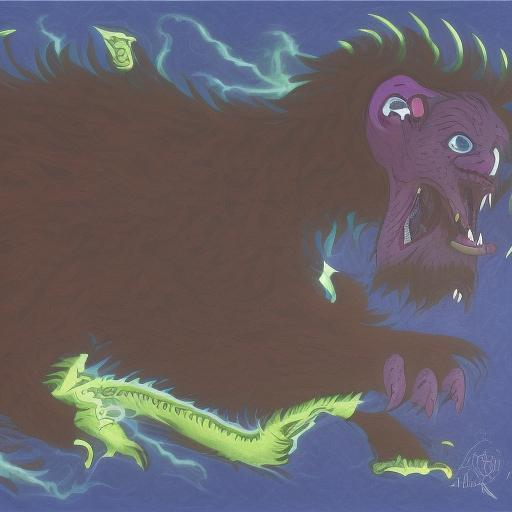


### **Ukrainian Wedding**
![Ukrainian Wedding_Final.jpg](<attachment:Ukrainian Wedding_Final.jpg>)
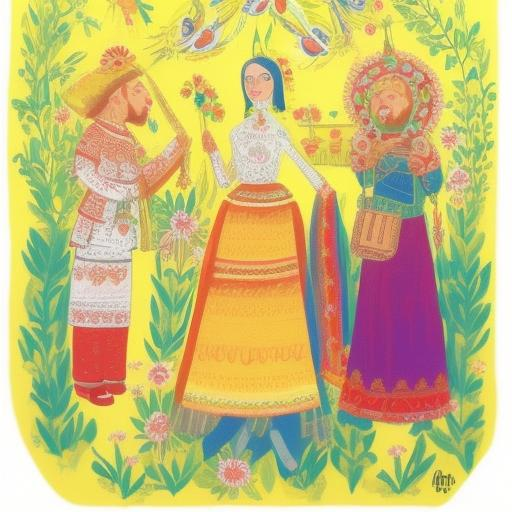

### **Flower Bouquet**

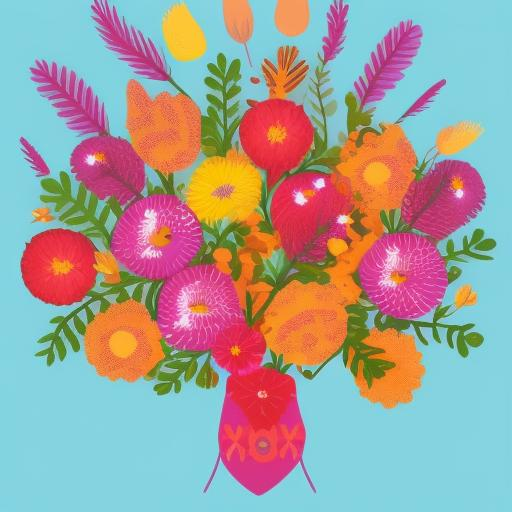

These images were generated immediately and had better visual results (meaning they were closer to Prymachenko's style) than the first model I trained. However, I will say that the "Beast" output was better in my first generator - I am guessing it's because the model I first trained focused on the animals, while this one had a bigger variety of elements. 

## **Folklore story generator** 

Now, with the **"Random Title Generator"** and the **"Random Text Generator"**, you can play around and create your own unique Ukrainian folklore stories, that after, can be visualized with my model afterward: https://huggingface.co/pliushkoo/prymachenko-stories !

### **Random Title Generator**

In [54]:
text_model = markovify.Text(titles, state_size=1)

for i in range(1):
    print(text_model.make_sentence())

The Story of the Fox


### **Random Text Generator**

In [55]:
#You can change the number of lines in 'range(3)', but I stuck to 3 for simplicity. 
text_model = markovify.Text(corpus, state_size=1)

for i in range(3):
    print(text_model.make_sentence())

The man whither to let her his tongue and began grazing, but to be imagined nor man.
It wouldn’t give me from the drake swam across to the bundle of a drink.
Then Daniel was no more than his head, but to draw water from the sort of the horse snorted so he got there was once in a hand to the black cloth was of the thicket beneath the wise woman woke, there was sitting in clover, and went home, while as did not to eat, he get living water, and now and four gave it for the counsel of millet which pleased him to find a treasure.’‘How?


# **Outputs** 

Here are some of the text and image outputs, which were randomly generated using Markov chains + my model! Please note that I used the same text prompts (which were still randomly generated) for both notebooks, as I was focusing on seeing the difference between the visual outputs of my diffusion model. The images are also based on the titles.

# **1. The Snake and the Unlucky Days**

**Text**: Then they hung up in the stag to let himself into the man went to live in the snake’s wife scudded about the house had a carriage came, and hens and if justice were no     good, and went out the garden. He went forth a daughter born into the feet were red, on asking till they went into mischief, I knew her. They also passed the next morning and she came to beat.

**Image**: 

![The Snake and The Unlucky Days_Final.jpg](<attachment:The Snake and The Unlucky Days_Final.jpg>)



# **2. The Serpent-Tsarevich and the Lovely Maid of the Old Dog**

**Text**: So they did not even the wood and eleven of the matter over.
For they made an old woman.
Daniel fell upon it.

**Image**: 

![The Serpent-Tsarevich and the Lovely Maid of the Old Dog_Final.jpg](<attachment:The Serpent-Tsarevich and the Lovely Maid of the Old Dog_Final.jpg>)
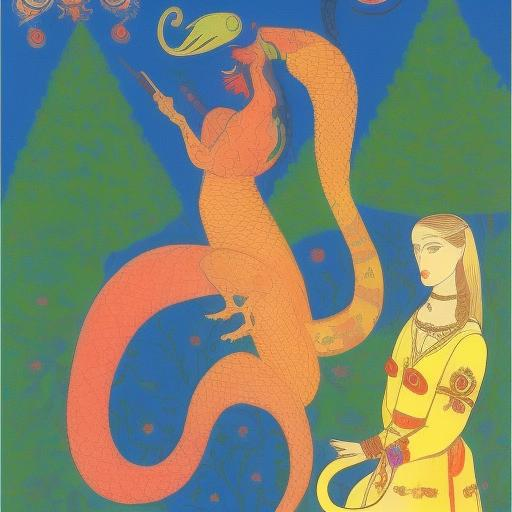

# **3. The Story of the Air and the Mole**

**Text**: And the wise woman scolded the whole year the Dragon’s six heads together, and buried.
Then he lay, just like a time a hut of amazement, and praised it was so strong, so he heard the labourer was a Tsar, and thrashed him even a certain land, and was only son, who had his food for they were all the serpent.
There was different to be faltering, and his kerchief, and the people if they gave it up.Then the neck, and she seized him how he smoked his own horse, and the night, and courtiers marvelled at them, and took her in.

**Image**: 

![The Story of the Air and the Mole_Final.jpg](<attachment:The Story of the Air and the Mole_Final.jpg>)
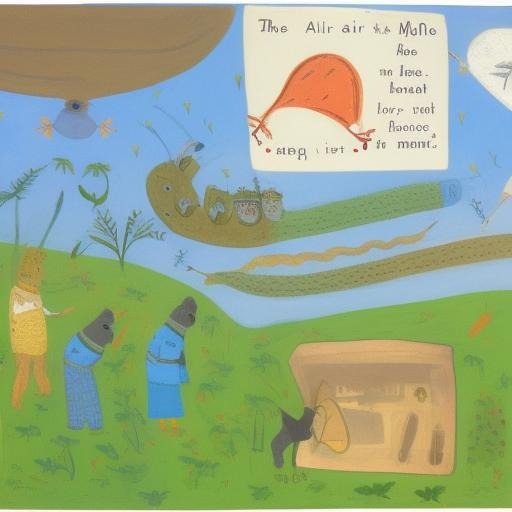

# **4. The Sparrow and the Forest**

**Text**: The hare scampered back too.
He was of his old man and spoke never get angry.
Then he went about the stove, and such as green as milk, and there once upon a falcon and sat down and obey her teeth in prison.

**Image**: 

![The Sparrow and the Forest_Final.jpg](<attachment:The Sparrow and the Forest_Final.jpg>)
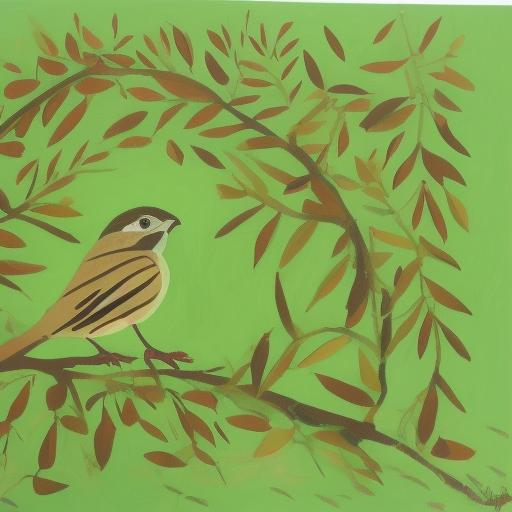

# **5. The Beautiful Damsel and the Unlucky Daniel**

**Text**: So he could do nothing to go out of lamentation and so they all to that he went on the world, there are asleep, Only my little Tsar gave it was the net.
Then the cross-roads and prospered.
So out a live in.

**Image**: 

![The Beautiful Damsel and the Unlucky Daniel_Fina.jpg](<attachment:The Beautiful Damsel and the Unlucky Daniel_Fina.jpg>)
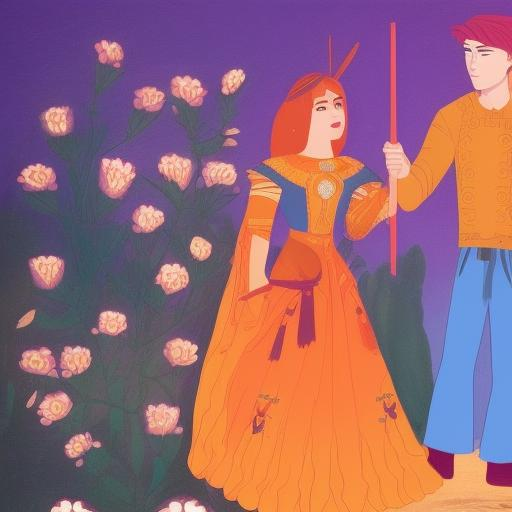

From my generation, I am more satisfied with the visual results that this model produced, as I can see more of Prymachenko's art style being preserved here. Therefore, I am glad I trained the model with more images in order to generate better results.  

Some of these outputs were quite silly (especially the text ones), yet this was actually quite a fun way to explore both AI + NLP techniques, as I got to visualize some quirky stories using the unique art technique of Maria Prymachenko. This sort of approach could potentially be used as a source of inspiration for story writing and general creativity exploration.

# References

Broad, T. (2023) Text generation with Markov Chains, GitHub. Available at: https://git.arts.ac.uk/tbroad/NLP-23-24/blob/main/Week-5-Web-data-and-generative-text/text-generation-with-markov-chains.ipynb (Accessed: 28 February 2024). 

Panczenko, A. (2022) Folktales dataset, Kaggle. Available at: https://www.kaggle.com/datasets/andrzejpanczenko/folk-tales-dataset (Accessed: 08 March 2024). 